# Workshop: Reti Neurali Convoluzionali (CNN)

Questo notebook presenta un approccio didattico alla costruzione e all'addestramento di una CNN, suddiviso in passi incrementali per facilitare la comprensione.

## 1. Importazione delle librerie necessarie

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Verifichiamo se è disponibile la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizzato: {device}")

Dispositivo utilizzato: cpu


## 2. Comprendere i layer convoluzionali

In [2]:
# Creiamo un singolo layer convoluzionale
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
print(f"Parametri del layer: {conv1.weight.shape}, {conv1.bias.shape}")

# Creiamo un input di esempio (una singola immagine 28x28 in bianco e nero)
input_example = torch.randn(1, 1, 28, 28)  # (batch_size, channels, height, width)

# Applichiamo la convoluzione
output = conv1(input_example)
print(f"Shape dell'output: {output.shape}")

Parametri del layer: torch.Size([6, 1, 5, 5]), torch.Size([6])
Shape dell'output: torch.Size([1, 6, 24, 24])


### Visualizziamo l'input e l'output della convoluzione

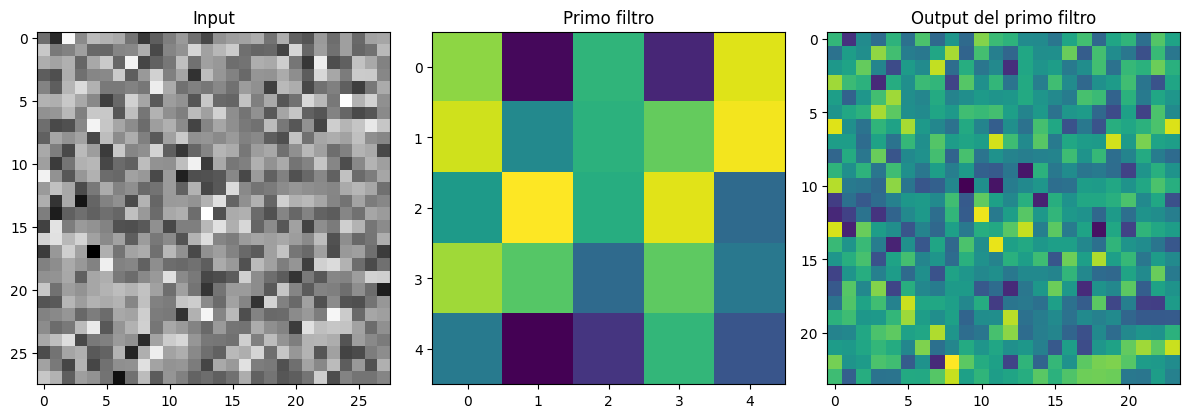

In [3]:
# Visualizziamo l'input
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(input_example[0, 0].detach().numpy(), cmap='gray')
plt.title('Input')

# Visualizziamo il primo filtro di convoluzione
plt.subplot(1, 3, 2)
plt.imshow(conv1.weight[0, 0].detach().numpy(), cmap='viridis')
plt.title('Primo filtro')

# Visualizziamo il primo canale dell'output
plt.subplot(1, 3, 3)
plt.imshow(output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Output del primo filtro')

plt.tight_layout()
plt.show()

### ESERCIZIO 1: Layer di Pooling

Applica un layer di MaxPooling all'output della convoluzione e visualizza il risultato.

In [ ]:
# Definisci un layer di MaxPooling con dimensione 2x2
# pool = ... Completa tu!

# Applica il pooling all'output della convoluzione
# pooled_output = ... Completa tu!

# Visualizza l'output originale e l'output dopo il pooling
# plt.figure(...) ... Completa tu!

## 3. Caricamento dei dati MNIST

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 257kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.08MB/s]


Shape dei dati: torch.Size([64, 1, 28, 28]), Shape delle etichette: torch.Size([64])


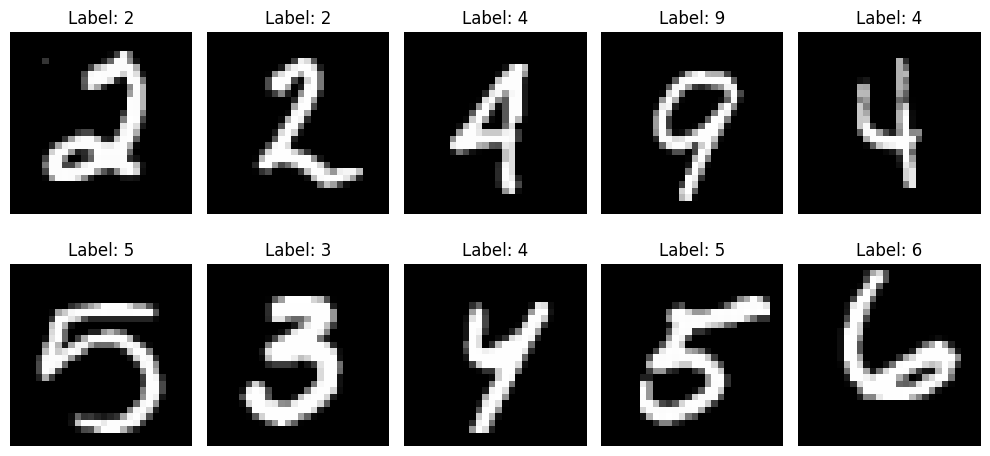

In [4]:
# Definiamo le trasformazioni da applicare ai dati
transform = transforms.Compose([
    transforms.ToTensor(),                     # Converte l'immagine in un tensore
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizza con media e deviazione standard del dataset MNIST
])

# Carichiamo i dataset di training e test
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Creiamo i data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Visualizziamo alcune immagini dal dataset
examples = iter(train_loader)
samples, labels = next(examples)
print(f"Shape dei dati: {samples.shape}, Shape delle etichette: {labels.shape}")

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Costruzione incrementale di una CNN

### Definiamo un modello CNN semplice

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Primo layer convoluzionale seguito da ReLU e MaxPooling
        self.conv1 = nn.Conv2d(1, 6, 5)       # in_channels=1, out_channels=6, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2)        # kernel_size=2, stride=2
        
        # Secondo layer convoluzionale seguito da ReLU e MaxPooling
        self.conv2 = nn.Conv2d(6, 16, 5)      # in_channels=6, out_channels=16, kernel_size=5
        
        # Layer fully connected
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # input features = 16*4*4, output features = 120
        self.fc2 = nn.Linear(120, 84)         # input features = 120, output features = 84
        self.fc3 = nn.Linear(84, 10)          # input features = 84, output features = 10 (classi MNIST)

    def forward(self, x):
        # Stampiamo le dimensioni a ogni passo per capire come cambia il tensore
        print(f"Input shape: {x.shape}")
        
        # Primo blocco: Conv -> ReLU -> MaxPool
        x = self.conv1(x)
        print(f"Dopo conv1: {x.shape}")
        x = F.relu(x)
        x = self.pool(x)
        print(f"Dopo pool1: {x.shape}")
        
        # Secondo blocco: Conv -> ReLU -> MaxPool
        x = self.conv2(x)
        print(f"Dopo conv2: {x.shape}")
        x = F.relu(x)
        x = self.pool(x)
        print(f"Dopo pool2: {x.shape}")
        
        # Reshape per i layer fully connected
        x = x.view(-1, 16 * 4 * 4)
        print(f"Dopo reshape: {x.shape}")
        
        # Layer fully connected
        x = F.relu(self.fc1(x))
        print(f"Dopo fc1: {x.shape}")
        x = F.relu(self.fc2(x))
        print(f"Dopo fc2: {x.shape}")
        x = self.fc3(x)
        print(f"Output finale: {x.shape}")
        
        return x

# Creiamo un'istanza del modello
model = SimpleCNN()

# Testiamo il forward pass con un batch di esempio
batch = next(iter(train_loader))[0][:2]  # Prendiamo solo 2 immagini per vedere il flusso
output = model(batch)

# Una volta capito il flusso, creiamo una versione senza i print per l'addestramento
class TrainableCNN(nn.Module):
    def __init__(self):
        super(TrainableCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Creiamo il modello per l'addestramento
train_model = TrainableCNN().to(device)

Input shape: torch.Size([2, 1, 28, 28])
Dopo conv1: torch.Size([2, 6, 24, 24])
Dopo pool1: torch.Size([2, 6, 12, 12])
Dopo conv2: torch.Size([2, 16, 8, 8])
Dopo pool2: torch.Size([2, 16, 4, 4])
Dopo reshape: torch.Size([2, 256])
Dopo fc1: torch.Size([2, 120])
Dopo fc2: torch.Size([2, 84])
Output finale: torch.Size([2, 10])


### ESERCIZIO 2: Completa il modello CNN con Batch Normalization

Implementa una variante della CNN che includa Batch Normalization dopo ogni layer convoluzionale.

In [7]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        # Primo blocco: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Aggiungi qui il BatchNorm2d per 6 canali
        # self.bn1 = ... Completa tu!
        self.pool = nn.MaxPool2d(2, 2)
        
        # Secondo blocco: Conv -> BatchNorm -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Aggiungi qui il BatchNorm2d per 16 canali
        # self.bn2 = ... Completa tu!
        
        # Layer fully connected
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Implementa il forward pass usando i layer batch norm
        # x = ... Completa tu!
        return x

### ESERCIZIO 3: Implementa una CNN con Dropout

Implementa una variante della CNN che includa Dropout nei layer fully connected per evitare l'overfitting.

In [8]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        # Layer convoluzionali
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Aggiungi qui il Dropout
        # self.dropout1 = ... Completa tu!
        # self.dropout2 = ... Completa tu!
        
        # Layer fully connected
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Implementa il forward pass usando i layer dropout
        # x = ... Completa tu!
        return x

## 5. Addestramento della CNN con loop esplicito

In [9]:
# Prepariamo il modello, la loss function e l'optimizer
model = TrainableCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Lista per tracciare la loss durante il training
training_loss = []

# Parametri di addestramento
num_epochs = 3  # Ridotto per scopi didattici

# Loop di addestramento
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Imposta il modello in modalità di addestramento
    
    # Iteriamo su tutti i batch del dataset di training
    for i, data in enumerate(train_loader, 0):
        # Otteniamo input e label dal dataloader e li spostiamo sul device
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Azzeriamo i gradienti accumulati
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calcoliamo la loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Optimization step
        optimizer.step()
        
        # Accumuliamo la loss per statistiche
        running_loss += loss.item()
        
        # Stampiamo statistiche ogni 100 batch
        if i % 100 == 99:
            current_loss = running_loss / 100
            training_loss.append(current_loss)
            print(f'[Epoca {epoch + 1}, Batch {i + 1}] Loss: {current_loss:.3f}')
            running_loss = 0.0
            
            # Calcoliamo l'accuracy sul batch corrente
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            print(f'Accuracy sul batch: {100 * correct / total:.2f}%')
            
            # Salviamo un checkpoint
            if i % 500 == 499:
                torch.save(model.state_dict(), f"model_checkpoint_epoch{epoch+1}_batch{i+1}.pth")
                print("Checkpoint salvato!")
    
    # Valutiamo il modello sul dataset di test alla fine di ogni epoca
    model.eval()  # Imposta il modello in modalità di valutazione
    correct = 0
    total = 0
    with torch.no_grad():  # Disabilita il calcolo dei gradienti per la valutazione
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy sul test set dopo epoca {epoch+1}: {100 * correct / total:.2f}%')

print('Addestramento completato!')

[Epoca 1, Batch 100] Loss: 1.482
Accuracy sul batch: 84.38%
[Epoca 1, Batch 200] Loss: 0.323
Accuracy sul batch: 93.75%
[Epoca 1, Batch 300] Loss: 0.216
Accuracy sul batch: 95.31%
[Epoca 1, Batch 400] Loss: 0.169
Accuracy sul batch: 90.62%
[Epoca 1, Batch 500] Loss: 0.128
Accuracy sul batch: 96.88%
Checkpoint salvato!
[Epoca 1, Batch 600] Loss: 0.099
Accuracy sul batch: 93.75%
[Epoca 1, Batch 700] Loss: 0.101
Accuracy sul batch: 98.44%
[Epoca 1, Batch 800] Loss: 0.106
Accuracy sul batch: 100.00%
[Epoca 1, Batch 900] Loss: 0.091
Accuracy sul batch: 98.44%
Accuracy sul test set dopo epoca 1: 97.74%
[Epoca 2, Batch 100] Loss: 0.083
Accuracy sul batch: 100.00%
[Epoca 2, Batch 200] Loss: 0.077
Accuracy sul batch: 100.00%
[Epoca 2, Batch 300] Loss: 0.065
Accuracy sul batch: 98.44%
[Epoca 2, Batch 400] Loss: 0.070
Accuracy sul batch: 98.44%
[Epoca 2, Batch 500] Loss: 0.068
Accuracy sul batch: 100.00%
Checkpoint salvato!
[Epoca 2, Batch 600] Loss: 0.069
Accuracy sul batch: 96.88%
[Epoca 2, Bat

### Visualizziamo l'andamento della loss durante l'addestramento

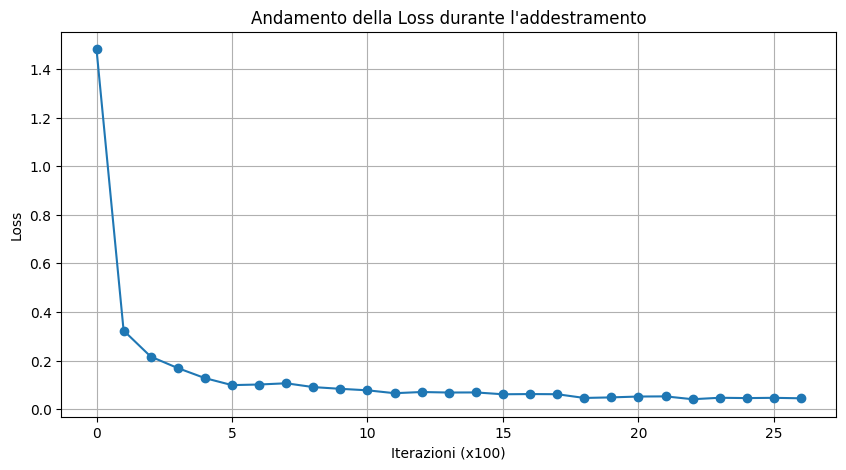

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(training_loss, '-o')
plt.title('Andamento della Loss durante l\'addestramento')
plt.xlabel('Iterazioni (x100)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Visualizziamo l'evoluzione dei pesi durante l'addestramento

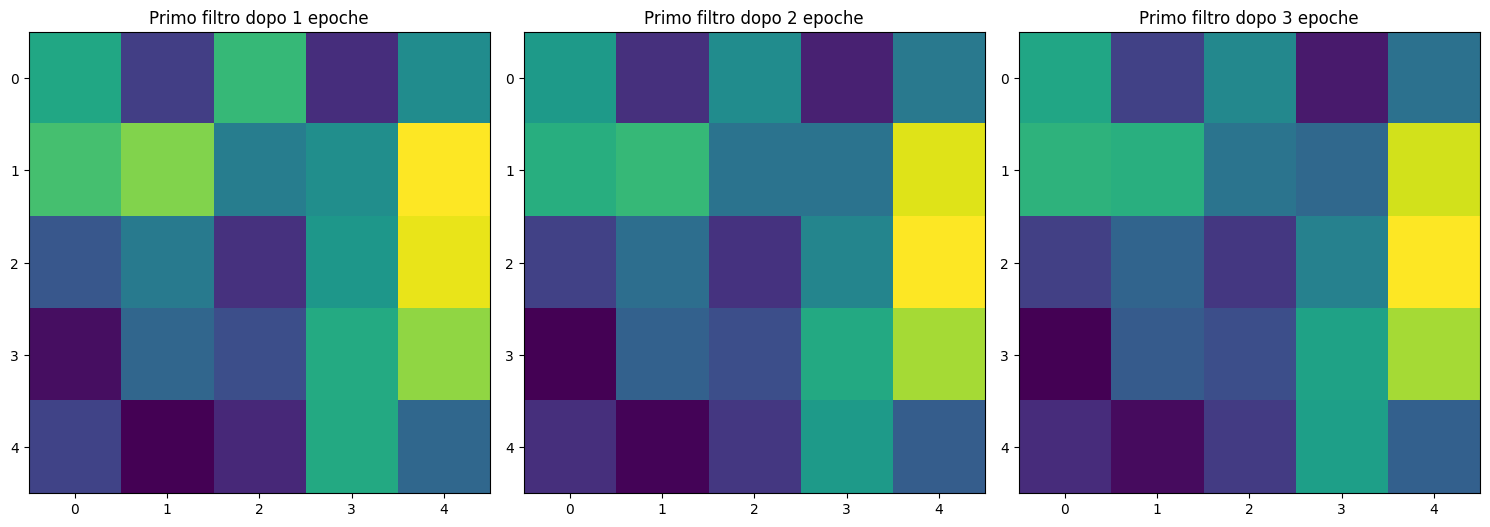

In [13]:
# Carichiamo i checkpoint salvati durante l'addestramento
checkpoints = [
    "model_checkpoint_epoch1_batch500.pth",
    "model_checkpoint_epoch2_batch500.pth",
    "model_checkpoint_epoch3_batch500.pth"
]

plt.figure(figsize=(15, 5))
for i, checkpoint in enumerate(checkpoints):
    try:
        # Creiamo un nuovo modello e carichiamo i pesi
        checkpoint_model = TrainableCNN()
        checkpoint_model.load_state_dict(torch.load(checkpoint))
        
        # Visualizziamo i primi filtri convoluzionali
        plt.subplot(1, 3, i+1)
        plt.imshow(checkpoint_model.conv2.weight[0, 0].detach().numpy(), cmap='viridis')
        plt.title(f'Primo filtro dopo {i+1} epoche')
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint} non trovato. Skippo la visualizzazione.")

plt.tight_layout()
plt.show()

## 6. Visualizzazione delle attivazioni della rete

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.9247036..6.7216315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.917291..13.73739].


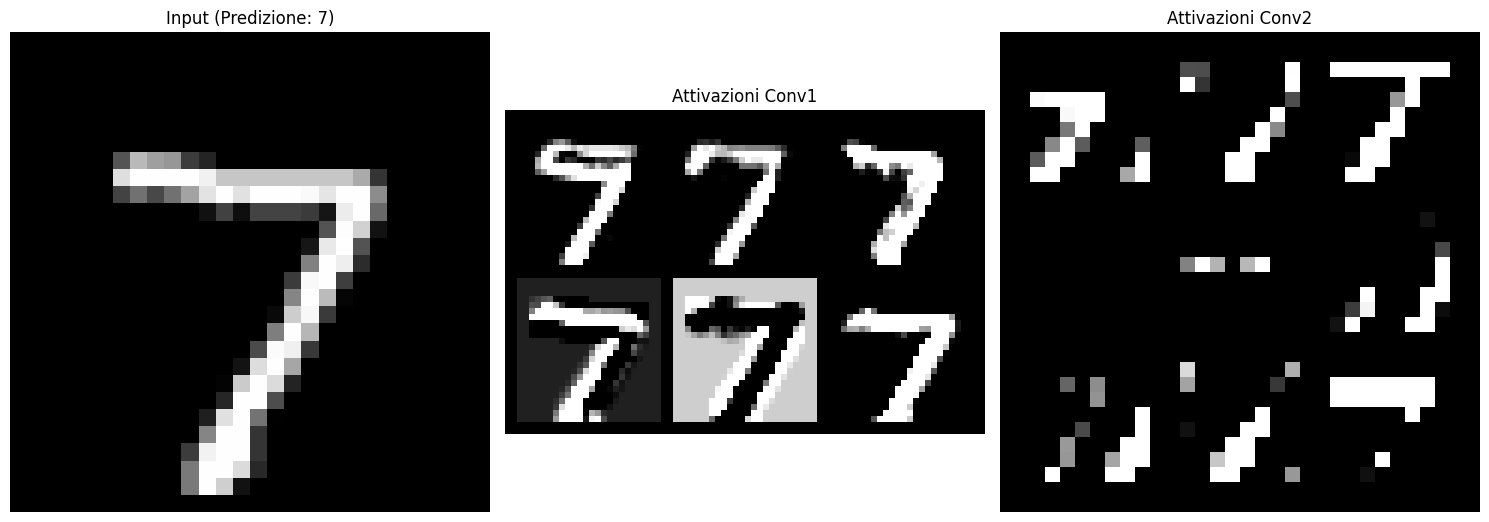

Label reale: 7, Predizione: 7


In [12]:
def visualize_activations(model, image):
    # Spostiamo l'immagine sul device
    image = image.to(device)
    
    # Dictionary per salvare le attivazioni
    activations = {}
    
    # Hook per catturare le attivazioni
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach().cpu()
        return hook
    
    # Registriamo gli hook sui layer che ci interessano
    hooks = [
        model.conv1.register_forward_hook(get_activation('conv1')),
        model.conv2.register_forward_hook(get_activation('conv2'))
    ]
    
    # Forward pass per ottenere le attivazioni
    model.eval()
    output = model(image)
    
    # Rimuoviamo gli hook
    for hook in hooks:
        hook.remove()
    
    # Otteniamo la predizione
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()
    
    # Visualizziamo l'immagine di input
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')
    plt.title(f'Input (Predizione: {predicted_class})')
    plt.axis('off')
    
    # Visualizziamo le attivazioni del primo layer convoluzionale
    plt.subplot(1, 3, 2)
    act1 = activations['conv1'][0]
    n_filters = min(9, act1.shape[0])  # Mostriamo massimo 9 filtri
    plt.imshow(torchvision.utils.make_grid(act1[:n_filters].unsqueeze(1), nrow=3).permute(1, 2, 0).numpy())
    plt.title('Attivazioni Conv1')
    plt.axis('off')
    
    # Visualizziamo le attivazioni del secondo layer convoluzionale
    plt.subplot(1, 3, 3)
    act2 = activations['conv2'][0]
    n_filters = min(9, act2.shape[0])  # Mostriamo massimo 9 filtri
    plt.imshow(torchvision.utils.make_grid(act2[:n_filters].unsqueeze(1), nrow=3).permute(1, 2, 0).numpy())
    plt.title('Attivazioni Conv2')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Prendiamo un'immagine dal test dataset
test_iter = iter(test_loader)
images, labels = next(test_iter)
single_image = images[0:1]  # Prendiamo solo la prima immagine
single_label = labels[0].item()

# Aggiungiamo il modulo torchvision se non è già stato importato
import torchvision

# Visualizziamo le attivazioni
prediction = visualize_activations(model, single_image)
print(f"Label reale: {single_label}, Predizione: {prediction}")

## 7. Valutazione finale del modello

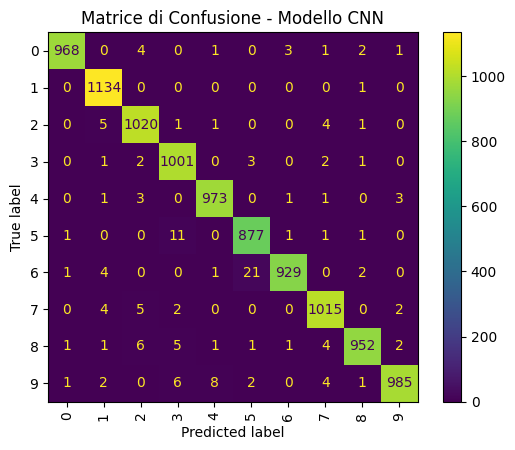

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Valutiamo il modello sul dataset di test e calcoliamo la matrice di confusione

# Impostiamo il modello in modalità di valutazione
model.eval()

# Liste per salvare le predizioni e le etichette reali
all_predictions = []
all_labels = []

# Disabilitiamo il calcolo dei gradienti
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcoliamo la matrice di confusione
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Visualizziamo la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(range(10)))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title('Matrice di Confusione - Modello CNN')
plt.show()